In [177]:
# #Read and parse data normally
# import os
# import pandas as pd
# import re


# def clean_split(data):
#     """ Cleans and properly splits a comma-separated string while preserving spaces in words like 'long-circle'. """
#     return [x.strip() for x in re.split(r",\s(?=[a-zA-Z])", data.strip(", "))] if data else []

# def parse_file(file_path):
#     with open(file_path, "r") as f:
#         content = f.read()

#     #print(f"Processing {file_path}")

#     timestamp_match = re.search(r"^([\d\-T:.Z]+), click,", content)
#     timestamp = timestamp_match.group(1) if timestamp_match else "Unknown"

#     times = re.findall(r"Times \(Movement Time\):\s*([\d., ]+) seconds", content)
#     distances = re.findall(r"Distances:\s*([\d., ]+)", content)
#     shapes = re.findall(r"Target Shapes:\s*([\w\- ,]+)", content)
#     positions = re.findall(r"\(([\d.]+)\s*,\s*([\d.]+)\)", content)
#     positions = [(float(x), float(y)) for x, y in positions] if positions else []

#     times = [float(x) for x in times[0].strip(", ").split(", ")] if times else []
#     distances = [float(x) for x in distances[0].strip(", ").split(", ")] if distances else []
#     shapes = clean_split(shapes[0]) if shapes else []

#     errors_section = re.search(r"Errors:\s*\n([\s\S]+?)\n\s*Overshoots", content)
#     errors = {}
#     if errors_section:
#         error_trials = re.findall(r"Trial (\d+):\s*([\d.]+(?:,\s*[\d.]+)*|None)", errors_section.group(1))
#         for trial, val in error_trials:
#             trial_num = int(trial)
#             errors[trial_num] = [float(x) for x in val.split(", ")] if val.lower() != "none" else []

#     overshoots_section = re.search(r"Overshoots \(correction times\):\s*\n([\s\S]+?)\n\s*Total Hover", content)
#     overshoots = {}
#     if overshoots_section:
#         overshoot_trials = re.findall(r"Trial (\d+):\s*([\d.]+(?:,\s*[\d.]+)*|None)", overshoots_section.group(1))
#         for trial, val in overshoot_trials:
#             trial_num = int(trial)
#             overshoots[trial_num] = [float(x) for x in val.split(", ")] if val.lower() != "none" else []

#     hover_times = re.findall(r"Total Hover Times \(per trial\):\s*([\d., ]+) seconds", content)
#     hover_times = [float(x) for x in hover_times[0].strip(", ").split(", ")] if hover_times else []

#     first_entry_click_delay = re.findall(r"First Entry Click Delays:\s*([\d., ]+) seconds", content)
#     first_entry_click_delay = [float(x) for x in first_entry_click_delay[0].strip(", ").split(", ")] if first_entry_click_delay else []

#     most_recent_click_delay = re.findall(r"Most Recent Entry Click Delays:\s*([\d., ]+) seconds", content)
#     most_recent_click_delay = [float(x) for x in most_recent_click_delay[0].strip(", ").split(", ")] if most_recent_click_delay else []

#     cursor_path_match = re.search(r"Cursor Path:\n([\s\S]+)", content)
#     trial_cursor_paths = []
#     current_path = []

    
#     if cursor_path_match:
#         lines = cursor_path_match.group(1).strip().split("\n")
#         prev_time = None
        
#         for line in lines:
#             parts = line.split(", ")
#             if len(parts) == 3:
#                 try:
#                     time, x, y = float(parts[0]), float(parts[1]), float(parts[2])

#                     if prev_time is not None and time < prev_time:
#                         trial_cursor_paths.append(current_path)
#                         current_path = [] 

#                     current_path.append((time, x, y))
#                     prev_time = time
#                 except ValueError:
#                     pass  
        
#         if current_path:
#             trial_cursor_paths.append(current_path)

#     while len(trial_cursor_paths) < len(times):
#         trial_cursor_paths.append([])  

#     trials = []
#     for i in range(len(times)):
#         trials.append({
#             "timestamp": timestamp,
#             "trial": i + 1,
#             "total_time": times[i] if i < len(times) else None,
#             "distance": distances[i] if i < len(distances) else None,
#             "target_shape": shapes[i] if i < len(shapes) else None,
#             "target_position": positions[i] if i < len(positions) else None,
#             "errors": errors.get(i + 1, []),
#             "overshoot_correction_times": overshoots.get(i + 1, []),
#             "hover_time": hover_times[i] if i < len(hover_times) else None,
#             "first_entry_click_delay": first_entry_click_delay[i] if i < len(first_entry_click_delay) else None,
#             "most_recent_click_delay": most_recent_click_delay[i] if i < len(most_recent_click_delay) else None,
#             "session_cursor_path": trial_cursor_paths[i] if i < len(trial_cursor_paths) else []
#         })

#     return trials

# from natsort import natsorted 

# all_trials = []

# folder_path = "data/mouse"
# for filename in natsorted(os.listdir(folder_path)): 
#     if filename.endswith(".txt"):
#         file_path = os.path.join(folder_path, filename)
#         all_trials.extend(parse_file(file_path))
# print(f"Mouse: Processed {len(all_trials)} trials from {len(os.listdir(folder_path))} files.")
# df_mouse = pd.DataFrame(all_trials)

# folder_path = "data/glove"
# all_trials = []  # Reset all_trials for glove data
# for filename in natsorted(os.listdir(folder_path)): 
#     if filename.endswith(".txt"):
#         file_path = os.path.join(folder_path, filename)
#         all_trials.extend(parse_file(file_path))
# print(f"Glove: Processed {len(all_trials)} trials from {len(os.listdir(folder_path))} files.")
# df_glove = pd.DataFrame(all_trials)


In [178]:
# Read data with path start point and end point manually inserted
screen_center = (720, 325)  

def parse_file(file_path):
    with open(file_path, "r") as f:
        content = f.read()

    #print(f"Processing {file_path}")

    timestamp_match = re.search(r"^([\d\-T:.Z]+), click,", content)
    timestamp = timestamp_match.group(1) if timestamp_match else "Unknown"

    times = re.findall(r"Times \(Movement Time\):\s*([\d., ]+) seconds", content)
    distances = re.findall(r"Distances:\s*([\d., ]+)", content)
    shapes = re.findall(r"Target Shapes:\s*([\w\- ,]+)", content)
    positions = re.findall(r"\(([\d.]+)\s*,\s*([\d.]+)\)", content)
    positions = [(float(x), float(y)) for x, y in positions] if positions else []

    times = [float(x) for x in times[0].strip(", ").split(", ")] if times else []
    distances = [float(x) for x in distances[0].strip(", ").split(", ")] if distances else []
    shapes = clean_split(shapes[0]) if shapes else []

    errors_section = re.search(r"Errors:\s*\n([\s\S]+?)\n\s*Overshoots", content)
    errors = {}
    if errors_section:
        error_trials = re.findall(r"Trial (\d+):\s*([\d.]+(?:,\s*[\d.]+)*|None)", errors_section.group(1))
        for trial, val in error_trials:
            trial_num = int(trial)
            errors[trial_num] = [float(x) for x in val.split(", ")] if val.lower() != "none" else []

    overshoots_section = re.search(r"Overshoots \(correction times\):\s*\n([\s\S]+?)\n\s*Total Hover", content)
    overshoots = {}
    if overshoots_section:
        overshoot_trials = re.findall(r"Trial (\d+):\s*([\d.]+(?:,\s*[\d.]+)*|None)", overshoots_section.group(1))
        for trial, val in overshoot_trials:
            trial_num = int(trial)
            overshoots[trial_num] = [float(x) for x in val.split(", ")] if val.lower() != "none" else []

    hover_times = re.findall(r"Total Hover Times \(per trial\):\s*([\d., ]+) seconds", content)
    hover_times = [float(x) for x in hover_times[0].strip(", ").split(", ")] if hover_times else []

    first_entry_click_delay = re.findall(r"First Entry Click Delays:\s*([\d., ]+) seconds", content)
    first_entry_click_delay = [float(x) for x in first_entry_click_delay[0].strip(", ").split(", ")] if first_entry_click_delay else []

    most_recent_click_delay = re.findall(r"Most Recent Entry Click Delays:\s*([\d., ]+) seconds", content)
    most_recent_click_delay = [float(x) for x in most_recent_click_delay[0].strip(", ").split(", ")] if most_recent_click_delay else []

    cursor_path_match = re.search(r"Cursor Path:\n([\s\S]+)", content)
    trial_cursor_paths = []
    current_path = []
    prev_target_position = screen_center 

    if cursor_path_match:
        lines = cursor_path_match.group(1).strip().split("\n")
        prev_time = None

        for line in lines:
            parts = line.split(", ")
            if len(parts) == 3:
                try:
                    time, x, y = float(parts[0]), float(parts[1]), float(parts[2])

                    if prev_time is not None and time < prev_time:
                        if prev_target_position:
                            current_path.append((time, *prev_target_position))
                        trial_cursor_paths.append(current_path)
                        current_path = [] 

                    current_path.append((time, x, y))
                    prev_time = time
                except ValueError:
                    pass  

        if current_path:
            current_path.append((time, *prev_target_position))  
            trial_cursor_paths.append(current_path)

    adjusted_paths = []
    for i, path in enumerate(trial_cursor_paths):
        start_point = screen_center if i == 0 else positions[i - 1] 
        end_point = positions[i] if i < len(positions) else None  

        if path:
            adjusted_path = [(0, *start_point)] + path
            if end_point:
                adjusted_path.append((path[-1][0] + 1, *end_point)) 
            adjusted_paths.append(adjusted_path)
        else:
            adjusted_paths.append([])

    while len(adjusted_paths) < len(times):
        adjusted_paths.append([])  

    trials = []
    for i in range(len(times)):
        trials.append({
            "timestamp": timestamp,
            "trial": i + 1,
            "total_time": times[i] if i < len(times) else None,
            "distance": distances[i] if i < len(distances) else None,
            "target_shape": shapes[i] if i < len(shapes) else None,
            "target_position": positions[i] if i < len(positions) else None,
            "errors": errors.get(i + 1, []),
            "overshoot_correction_times": overshoots.get(i + 1, []),
            #"hover_time": hover_times[i] if i < len(hover_times) else None,
            "hover_time": hover_times[i] + most_recent_click_delay[i] if (first_entry_click_delay[i] != most_recent_click_delay[i]) else hover_times[i],
            "first_entry_click_delay": first_entry_click_delay[i] if i < len(first_entry_click_delay) else None,
            "most_recent_click_delay": most_recent_click_delay[i] if i < len(most_recent_click_delay) else None,
            "session_cursor_path": adjusted_paths[i] if i < len(adjusted_paths) else []
        })

    return trials

def clean_split(data):
    """ Cleans and properly splits a comma-separated string while preserving spaces in words like 'long-circle'. """
    return [x.strip() for x in re.split(r",\s(?=[a-zA-Z])", data.strip(", "))] if data else []

from natsort import natsorted 

all_trials = []

folder_path = "data/mouse"
for filename in natsorted(os.listdir(folder_path)): 
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)
        all_trials.extend(parse_file(file_path))
print(f"Mouse: Processed {len(all_trials)} trials from {len(os.listdir(folder_path))} files.")
df_mouse = pd.DataFrame(all_trials)

folder_path = "data/glove"
all_trials = []  
for filename in natsorted(os.listdir(folder_path)): 
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)
        all_trials.extend(parse_file(file_path))
print(f"Glove: Processed {len(all_trials)} trials from {len(os.listdir(folder_path))} files.")
df_glove = pd.DataFrame(all_trials)

Mouse: Processed 255 trials from 51 files.
Glove: Processed 295 trials from 60 files.


In [179]:
#Calculating the other metrics/features
import numpy as np

def process_dataframe(df, screen_center):
    df["prev_target_distance"] = np.nan
    df["velocity"] = np.nan
    df["error_count"] = df["errors"].apply(len)
    df["total_overshoot_time"] = df["overshoot_correction_times"].apply(sum)
    df["actual_path_length"] = np.nan
    df["optimal_path_ratio"] = np.nan
    df["extra_movement_percentage"] = np.nan
    
    for i in range(len(df)):
        if df.loc[i, "target_position"] is not None:
            if df.loc[i, "trial"] % 5 == 0:  
                prev_x, prev_y = screen_center
            else: 
                prev_x, prev_y = df.loc[i - 1, "target_position"] if i > 0 else screen_center

            x, y = df.loc[i, "target_position"]
            df.loc[i, "prev_target_distance"] = np.sqrt((x - prev_x) ** 2 + (y - prev_y) ** 2)

            if df.loc[i, "total_time"] > 0:
                df.loc[i, "velocity"] = df.loc[i, "prev_target_distance"] / df.loc[i, "total_time"]

            if df.loc[i, "session_cursor_path"]:
                path = np.array([(x, y) for _, x, y in df.loc[i, "session_cursor_path"]])
                actual_path_length = np.sum(np.linalg.norm(np.diff(path, axis=0), axis=1))
                df.loc[i, "actual_path_length"] = actual_path_length

                if df.loc[i, "prev_target_distance"] > 0:
                    df.loc[i, "optimal_path_ratio"] = actual_path_length / df.loc[i, "prev_target_distance"]
                    df.loc[i, "extra_movement_percentage"] = (actual_path_length - df.loc[i, "prev_target_distance"]) / df.loc[i, "prev_target_distance"]
    
    cols = [col for col in df.columns if col != "session_cursor_path"] + ["session_cursor_path"]
    return df[cols]

screen_center = (720, 325)

df_mouse = process_dataframe(df_mouse, screen_center)
df_glove = process_dataframe(df_glove, screen_center)

In [180]:
df_mouse.head()

,timestamp,trial,total_time,distance,target_shape,target_position,errors,overshoot_correction_times,hover_time,first_entry_click_delay,most_recent_click_delay,prev_target_distance,velocity,error_count,total_overshoot_time,actual_path_length,optimal_path_ratio,extra_movement_percentage,session_cursor_path
0,2025-03-22T16:33:25.418Z,1,1.071,576.48,long-rectangle,"(304.2, 489.7)",[],[],0.212,0.212,0.212,447.231182,417.582803,0,0.0,1587.296854,3.549164,2.549164,"[(0, 720, 325), (155.2, 708.0, 406.0), (161.6,..."
1,2025-03-22T16:33:25.418Z,2,0.773,631.02,long-rectangle,"(539.9, 326.6)",[],[],0.314,0.314,0.314,286.628854,370.800587,0,0.0,879.096166,3.067019,2.067019,"[(0, 304.2, 489.7), (126.0, 311.0, 644.0), (14..."
2,2025-03-22T16:33:25.418Z,3,0.767,774.31,long-circle,"(670.6, 387.1)",[],[],0.312,0.312,0.312,144.023401,187.774969,0,0.0,688.826770,4.782742,3.782742,"[(0, 539.9, 326.6), (34.8, 552.0, 537.0), (52...."
3,2025-03-22T16:33:25.418Z,4,0.906,321.98,rectangle,"(175.4, 270.0)",[],[],0.429,0.429,0.429,508.857003,561.652322,0,0.0,1843.648145,3.623116,2.623116,"[(0, 670.6, 387.1), (38.6, 723.0, 535.0), (55...."
4,2025-03-22T16:33:25.418Z,5,0.827,885.61,long-circle,"(844.1, 268.1)",[],[],0.368,0.368,0.368,136.522599,165.081740,0,0.0,1169.905184,8.569315,7.569315,"[(0, 175.4, 270.0), (108.1, 201.0, 411.0), (12..."


In [181]:
df_glove.head()

,timestamp,trial,total_time,distance,target_shape,target_position,errors,overshoot_correction_times,hover_time,first_entry_click_delay,most_recent_click_delay,prev_target_distance,velocity,error_count,total_overshoot_time,actual_path_length,optimal_path_ratio,extra_movement_percentage,session_cursor_path
0,2025-03-29T18:37:19.074Z,1,2.800,1348.45,long-circle,"(1333.1, 202.9)",[],[0.782],0.813,1.248,0.348,625.140000,223.264286,0,0.782,2301.736275,3.681953,2.681953,"[(0, 720, 325), (239.2, 612.0, 407.0), (253.3,..."
1,2025-03-29T18:37:19.074Z,2,3.112,1258.76,rectangle,"(1150.0, 511.8)",[],[],1.238,1.238,1.238,359.088875,115.388456,0,0.000,1692.677840,4.713813,3.713813,"[(0, 1333.1, 202.9), (263.0, 1383.0, 361.0), (..."
2,2025-03-29T18:37:19.074Z,3,4.042,690.23,square,"(470.0, 505.5)",[],[1.884],0.870,2.361,0.394,680.029183,168.240768,0,1.884,1857.600701,2.731649,1.731649,"[(0, 1150.0, 511.8), (457.2, 1174.0, 668.0), (..."
3,2025-03-29T18:37:19.074Z,4,3.912,1250.33,long-rectangle,"(1243.8, 127.7)",[],[1.1],1.466,1.883,0.683,861.103525,220.118488,0,1.100,2301.710710,2.672978,1.672978,"[(0, 470.0, 505.5), (347.0, 486.0, 667.0), (36..."
4,2025-03-29T18:37:19.074Z,5,1.831,1111.65,rectangle,"(1073.7, 288.1)",[],[],0.510,0.510,0.510,355.619600,194.221518,0,0.000,1176.666772,3.308779,2.308779,"[(0, 1243.8, 127.7), (426.6, 1274.0, 283.0), (..."


In [182]:
# Find rows with NaN values in any column
rows_with_nan = df_glove[df_glove.isna().any(axis=1)]

# Print the rows with NaN values
print("Rows with NaN values:")
rows_with_nan


Rows with NaN values:


,timestamp,trial,total_time,distance,target_shape,target_position,errors,overshoot_correction_times,hover_time,first_entry_click_delay,most_recent_click_delay,prev_target_distance,velocity,error_count,total_overshoot_time,actual_path_length,optimal_path_ratio,extra_movement_percentage,session_cursor_path


In [183]:
# #MOUSE CALCS BUT LIKE separate -- DONT RUN
# import numpy as np

# # Assume screen center at (960, 540)
# screen_center = (720, 325)

# # Add new columns
# df_mouse["prev_target_distance"] = np.nan
# df_mouse["velocity"] = np.nan
# df_mouse["error_count"] = df_mouse["errors"].apply(len)
# df_mouse["total_overshoot_time"] = df_mouse["overshoot_correction_times"].apply(sum)
# df_mouse["actual_path_length"] = np.nan
# df_mouse["optimal_path_ratio"] = np.nan
# df_mouse["extra_movement_percentage"] = np.nan

# # Compute distances and path efficiency
# for i in range(len(df_mouse)):
#     if df_mouse.loc[i, "target_position"] is not None:
#         if df_mouse.loc[i, "trial"] % 5 == 0:  # First trial in set
#             prev_x, prev_y = screen_center
#         else:  # Use previous target position
#             prev_x, prev_y = df_mouse.loc[i - 1, "target_position"] if i > 0 else screen_center

#         # Compute Euclidean distance
#         x, y = df_mouse.loc[i, "target_position"]
#         df_mouse.loc[i, "prev_target_distance"] = np.sqrt((x - prev_x) ** 2 + (y - prev_y) ** 2)

#         # Compute velocity (distance/time)
#         if df_mouse.loc[i, "total_time"] > 0:
#             df_mouse.loc[i, "velocity"] = df_mouse.loc[i, "prev_target_distance"] / df_mouse.loc[i, "total_time"]

#         # Compute path efficiency
#         if df_mouse.loc[i, "session_cursor_path"]:
#             path = np.array([(x, y) for _, x, y in df_mouse.loc[i, "session_cursor_path"]])
#             actual_path_length = np.sum(np.linalg.norm(np.diff(path, axis=0), axis=1))
#             df_mouse.loc[i, "actual_path_length"] = actual_path_length

#             if df_mouse.loc[i, "prev_target_distance"] > 0:
#                 df_mouse.loc[i, "optimal_path_ratio"] = actual_path_length / df_mouse.loc[i, "prev_target_distance"]
#                 df_mouse.loc[i, "extra_movement_percentage"] = (actual_path_length - df_mouse.loc[i, "prev_target_distance"]) / df_mouse.loc[i, "prev_target_distance"]

# # Reorder columns
# cols = [col for col in df_mouse.columns if col != "session_cursor_path"] + ["session_cursor_path"]
# df_mouse = df_mouse[cols]

# df_mouse.head()


In [184]:
#GLOVE CALCS BUT LIKE separate -- DONT RUN
import numpy as np

# Assume screen center at (960, 540)
screen_center = (720, 325)  

# Add new columns
df_glove["prev_target_distance"] = np.nan
df_glove["velocity"] = np.nan
df_glove["error_count"] = df_glove["errors"].apply(len)
df_glove["total_overshoot_time"] = df_glove["overshoot_correction_times"].apply(sum)
df_glove["actual_path_length"] = np.nan
df_glove["optimal_path_ratio"] = np.nan
df_glove["extra_movement_percentage"] = np.nan

# Compute distances and path efficiency
for i in range(len(df_glove)):
    if df_glove.loc[i, "target_position"] is not None:
        if df_glove.loc[i, "trial"] % 5 == 0:  # First trial in set
            prev_x, prev_y = screen_center
        else:  # Use previous target position
            prev_x, prev_y = df_glove.loc[i - 1, "target_position"] if i > 0 else screen_center

        # Compute Euclidean distance
        x, y = df_glove.loc[i, "target_position"]
        df_glove.loc[i, "prev_target_distance"] = np.sqrt((x - prev_x) ** 2 + (y - prev_y) ** 2)

        # Compute velocity (distance/time)
        if df_glove.loc[i, "total_time"] > 0:
            df_glove.loc[i, "velocity"] = df_glove.loc[i, "prev_target_distance"] / df_glove.loc[i, "total_time"]

        # Compute path efficiency
        if df_glove.loc[i, "session_cursor_path"]:
            path = np.array([(x, y) for _, x, y in df_glove.loc[i, "session_cursor_path"]])
            actual_path_length = np.sum(np.linalg.norm(np.diff(path, axis=0), axis=1))
            df_glove.loc[i, "actual_path_length"] = actual_path_length

            if df_glove.loc[i, "prev_target_distance"] > 0:
                df_glove.loc[i, "optimal_path_ratio"] = actual_path_length / df_glove.loc[i, "prev_target_distance"]
                df_glove.loc[i, "extra_movement_percentage"] = (actual_path_length - df_glove.loc[i, "prev_target_distance"]) / df_glove.loc[i, "prev_target_distance"]

# Reorder columns
cols = [col for col in df_glove.columns if col != "session_cursor_path"] + ["session_cursor_path"]
df_glove = df_glove[cols]

df_glove.head()


,timestamp,trial,total_time,distance,target_shape,target_position,errors,overshoot_correction_times,hover_time,first_entry_click_delay,most_recent_click_delay,prev_target_distance,velocity,error_count,total_overshoot_time,actual_path_length,optimal_path_ratio,extra_movement_percentage,session_cursor_path
0,2025-03-29T18:37:19.074Z,1,2.800,1348.45,long-circle,"(1333.1, 202.9)",[],[0.782],0.813,1.248,0.348,625.140000,223.264286,0,0.782,2301.736275,3.681953,2.681953,"[(0, 720, 325), (239.2, 612.0, 407.0), (253.3,..."
1,2025-03-29T18:37:19.074Z,2,3.112,1258.76,rectangle,"(1150.0, 511.8)",[],[],1.238,1.238,1.238,359.088875,115.388456,0,0.000,1692.677840,4.713813,3.713813,"[(0, 1333.1, 202.9), (263.0, 1383.0, 361.0), (..."
2,2025-03-29T18:37:19.074Z,3,4.042,690.23,square,"(470.0, 505.5)",[],[1.884],0.870,2.361,0.394,680.029183,168.240768,0,1.884,1857.600701,2.731649,1.731649,"[(0, 1150.0, 511.8), (457.2, 1174.0, 668.0), (..."
3,2025-03-29T18:37:19.074Z,4,3.912,1250.33,long-rectangle,"(1243.8, 127.7)",[],[1.1],1.466,1.883,0.683,861.103525,220.118488,0,1.100,2301.710710,2.672978,1.672978,"[(0, 470.0, 505.5), (347.0, 486.0, 667.0), (36..."
4,2025-03-29T18:37:19.074Z,5,1.831,1111.65,rectangle,"(1073.7, 288.1)",[],[],0.510,0.510,0.510,355.619600,194.221518,0,0.000,1176.666772,3.308779,2.308779,"[(0, 1243.8, 127.7), (426.6, 1274.0, 283.0), (..."


In [185]:
df_mouse.columns, df_glove.columns

(Index(['timestamp', 'trial', 'total_time', 'distance', 'target_shape',
        'target_position', 'errors', 'overshoot_correction_times', 'hover_time',
        'first_entry_click_delay', 'most_recent_click_delay',
        'prev_target_distance', 'velocity', 'error_count',
        'total_overshoot_time', 'actual_path_length', 'optimal_path_ratio',
        'extra_movement_percentage', 'session_cursor_path'],
       dtype='object'),
 Index(['timestamp', 'trial', 'total_time', 'distance', 'target_shape',
        'target_position', 'errors', 'overshoot_correction_times', 'hover_time',
        'first_entry_click_delay', 'most_recent_click_delay',
        'prev_target_distance', 'velocity', 'error_count',
        'total_overshoot_time', 'actual_path_length', 'optimal_path_ratio',
        'extra_movement_percentage', 'session_cursor_path'],
       dtype='object'))

In [186]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import ast

# def safe_eval(val):
#     if isinstance(val, str):
#         return ast.literal_eval(val)
#     return val  # If it's already a tuple, return as is

# df_mouse["target_position"] = df_mouse["target_position"].apply(safe_eval)
# df_glove["target_position"] = df_glove["target_position"].apply(safe_eval)


def compute_fitts_law(df):
    # Map target shape to width (W)
    shape_widths = {
    "circle": 50,  # Assuming a 50px diameter
    "square": 50,  # Assuming 50x50px
    "rectangle": 100,  # Width of 100px
    "long-rectangle": 50,  # Width of 50px
    "long-circle": 100,  # Width of 100px
}

    # Assign widths based on shape
    df["W"] = df["target_shape"].map(shape_widths)

    # Compute Index of Difficulty (ID)
    df["ID"] = np.log2(df["prev_target_distance"] / df["W"] + 1)

    # Compute throughput (TP = ID / MT)
    df["throughput"] = df["ID"] / df["total_time"]

    # Fit Fitts' Law: MT = a + b * ID
    X = sm.add_constant(df["ID"])  # Add constant for intercept
    y = df["total_time"]
    model = sm.OLS(y, X).fit()

    return df, model

# Apply to mouse and glove dataframes
df_mouse, model_mouse = compute_fitts_law(df_mouse)
df_glove, model_glove = compute_fitts_law(df_glove)

# Print Fitts' Law parameters
print("Mouse Model:\n", model_mouse.summary())
print("Glove Model:\n", model_glove.summary())

# Compare Throughput
print("Mouse Throughput Mean:", df_mouse["throughput"].mean())
print("Glove Throughput Mean:", df_glove["throughput"].mean())

Mouse Model:
                             OLS Regression Results                            
Dep. Variable:             total_time   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     23.87
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           1.83e-06
Time:                        04:00:07   Log-Likelihood:                 58.165
No. Observations:                 255   AIC:                            -112.3
Df Residuals:                     253   BIC:                            -105.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7634      0.045     1

In [187]:
# Define a threshold for the optimal path ratio
threshold = 15.0  # Adjust this value as needed

# Drop the trials where the optimal path ratio is greater than the threshold
df_mouse = df_mouse[df_mouse["optimal_path_ratio"] <= threshold]
df_glove = df_glove[df_glove["optimal_path_ratio"] <= threshold]



### Movement Efficiency ###

optimal_path_ratio:
  Mouse Mean: 3.7455
  Glove Mean: 3.7665
  t-statistic: -0.1132, p-value: 0.9100
----------------------------------------


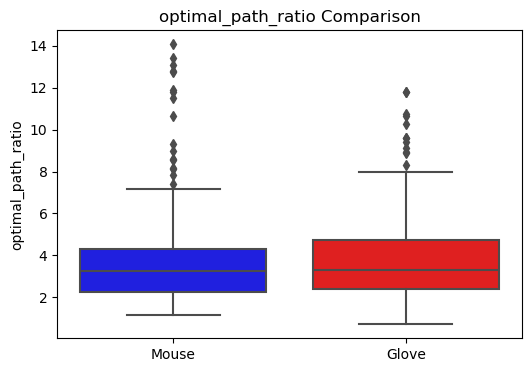

extra_movement_percentage:
  Mouse Mean: 2.7455
  Glove Mean: 2.7665
  t-statistic: -0.1132, p-value: 0.9100
----------------------------------------


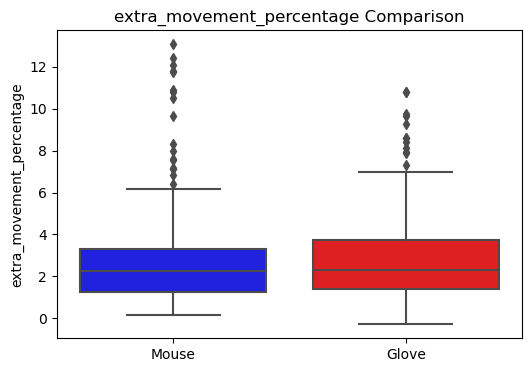


### Error Metrics ###

total_errors:
  Mouse Mean: 0.0360
  Glove Mean: 0.3106
  t-statistic: -1.9744, p-value: 0.0493
----------------------------------------


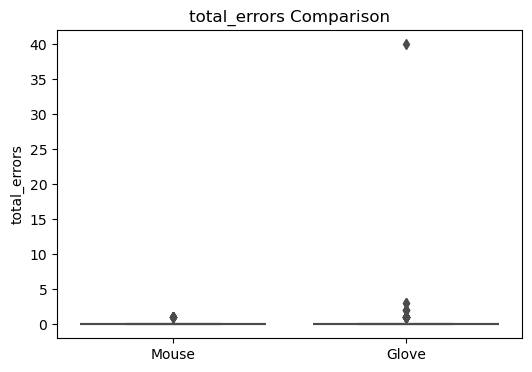

error_count:
  Mouse Mean: 0.0360
  Glove Mean: 0.3106
  t-statistic: -1.9744, p-value: 0.0493
----------------------------------------


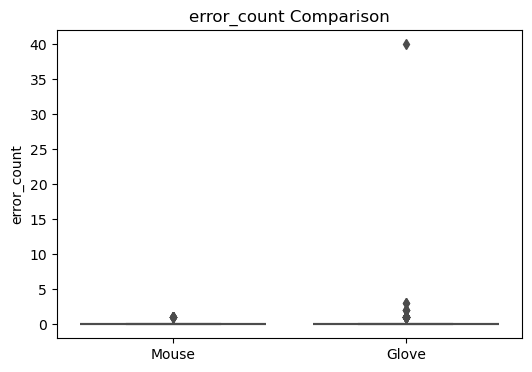

total_corrections:
  Mouse Mean: 0.1520
  Glove Mean: 0.1877
  t-statistic: -1.0184, p-value: 0.3089
----------------------------------------


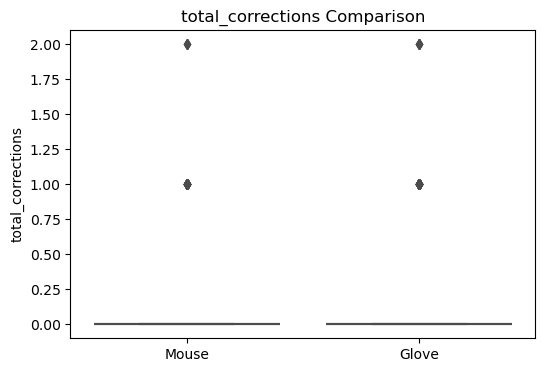


### Time-Based Error Handling ###

hover_time:
  Mouse Mean: 0.3484
  Glove Mean: 0.5088
  t-statistic: -5.4167, p-value: 0.0000
----------------------------------------


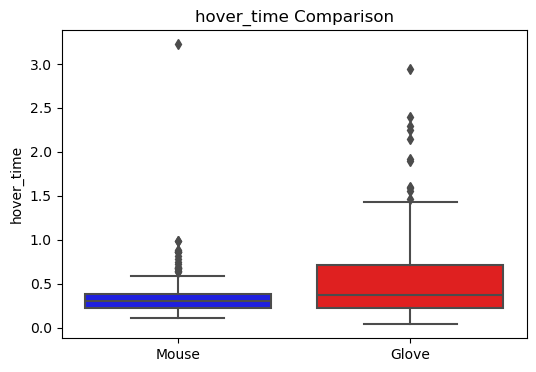

total_overshoot_time:
  Mouse Mean: 0.0377
  Glove Mean: 0.2914
  t-statistic: -5.6622, p-value: 0.0000
----------------------------------------


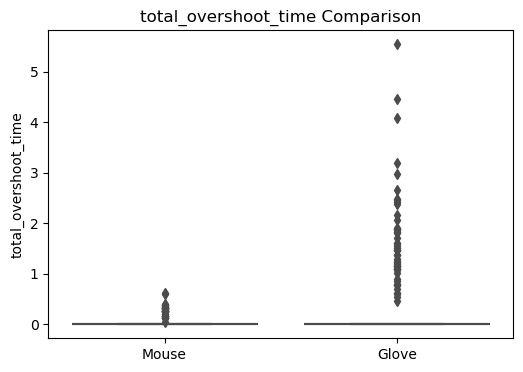

first_entry_click_delay:
  Mouse Mean: 0.3424
  Glove Mean: 0.7334
  t-statistic: -7.3245, p-value: 0.0000
----------------------------------------


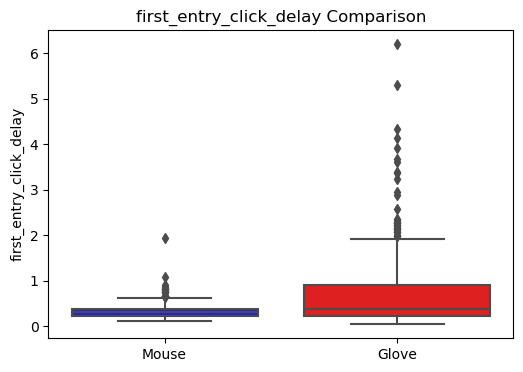

most_recent_click_delay:
  Mouse Mean: 0.2953
  Glove Mean: 0.4097
  t-statistic: -5.3538, p-value: 0.0000
----------------------------------------


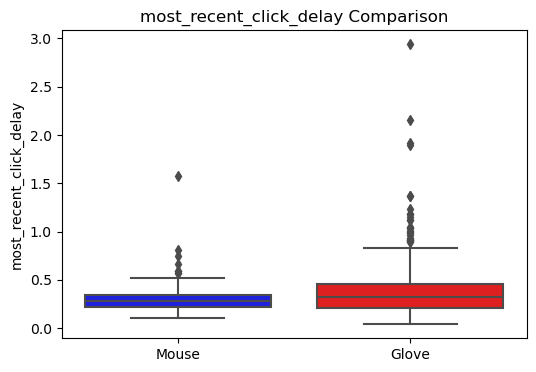

In [188]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Convert list-based metrics to numerical values
df_mouse["total_errors"] = df_mouse["errors"].apply(len)
df_glove["total_errors"] = df_glove["errors"].apply(len)

df_mouse["total_corrections"] = df_mouse["overshoot_correction_times"].apply(len)
df_glove["total_corrections"] = df_glove["overshoot_correction_times"].apply(len)

# Define movement and error metrics
movement_metrics = ["optimal_path_ratio", "extra_movement_percentage"]
error_metrics = ["total_errors", "error_count", "total_corrections"]  # Use counts instead of lists
time_based_errors = ["hover_time", "total_overshoot_time", "first_entry_click_delay", "most_recent_click_delay"]

# Function to summarize and compare metrics
def summarize_and_compare(df_mouse, df_glove, metrics, title):
    print(f"\n### {title} ###\n")

    for metric in metrics:
        mouse_mean = df_mouse[metric].mean()
        glove_mean = df_glove[metric].mean()
        stat, p_value = ttest_ind(df_mouse[metric], df_glove[metric], equal_var=False)  # Welch's t-test
        
        print(f"{metric}:")
        print(f"  Mouse Mean: {mouse_mean:.4f}")
        print(f"  Glove Mean: {glove_mean:.4f}")
        print(f"  t-statistic: {stat:.4f}, p-value: {p_value:.4f}")
        print("-" * 40)

        # Visualization
        plt.figure(figsize=(6, 4))
        sns.boxplot(data=[df_mouse[metric], df_glove[metric]], palette=["blue", "red"])
        plt.xticks([0, 1], ["Mouse", "Glove"])
        plt.title(f"{metric} Comparison")
        plt.ylabel(metric)
        plt.show()

# Run comparisons
summarize_and_compare(df_mouse, df_glove, movement_metrics, "Movement Efficiency")
summarize_and_compare(df_mouse, df_glove, error_metrics, "Error Metrics")
summarize_and_compare(df_mouse, df_glove, time_based_errors, "Time-Based Error Handling")



### Movement Efficiency ###

optimal_path_ratio:
  Mouse Mean: 3.7455
  Glove Mean: 3.7701
  t-statistic: -0.1330, p-value: 0.8943
----------------------------------------


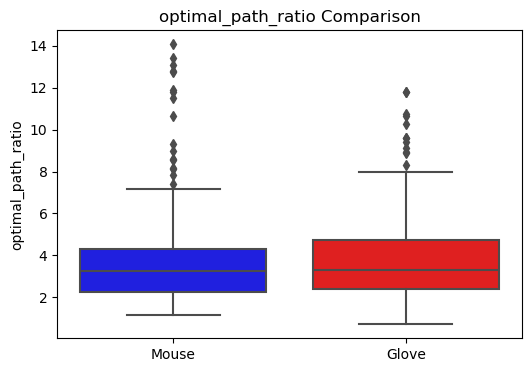

extra_movement_percentage:
  Mouse Mean: 2.7455
  Glove Mean: 2.7701
  t-statistic: -0.1330, p-value: 0.8943
----------------------------------------


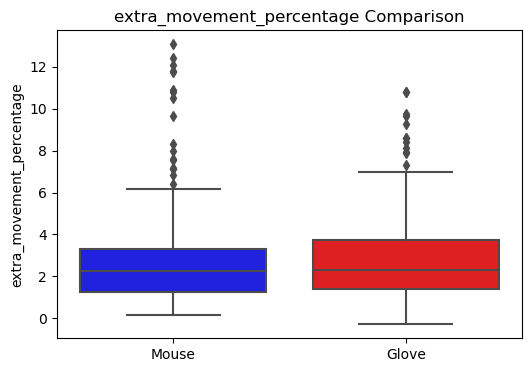


### Error Metrics ###

total_errors:
  Mouse Mean: 0.0360
  Glove Mean: 0.1747
  t-statistic: -4.7006, p-value: 0.0000
----------------------------------------


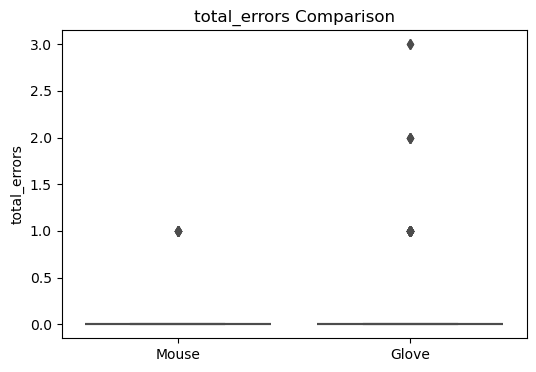

error_count:
  Mouse Mean: 0.0360
  Glove Mean: 0.1747
  t-statistic: -4.7006, p-value: 0.0000
----------------------------------------


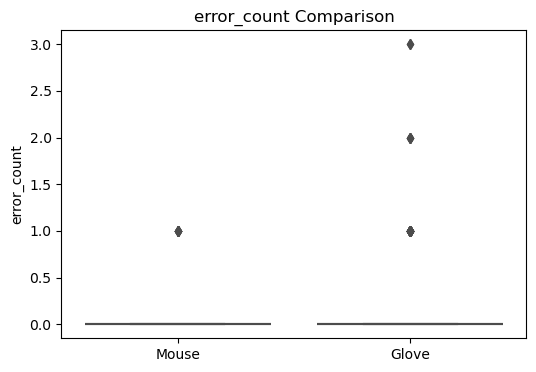

total_corrections:
  Mouse Mean: 0.1520
  Glove Mean: 0.1884
  t-statistic: -1.0351, p-value: 0.3011
----------------------------------------


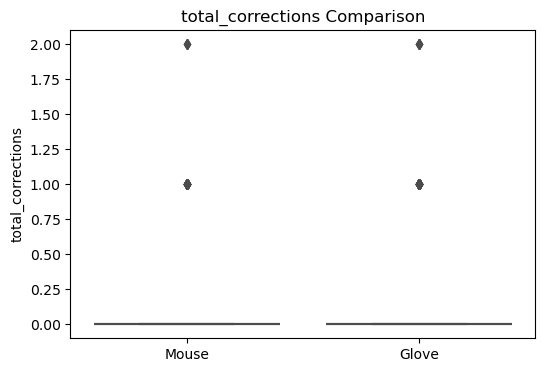


### Time-Based Error Handling ###

hover_time:
  Mouse Mean: 0.3484
  Glove Mean: 0.5096
  t-statistic: -5.4307, p-value: 0.0000
----------------------------------------


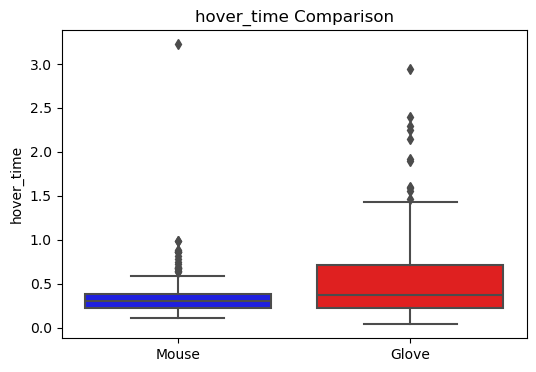

total_overshoot_time:
  Mouse Mean: 0.0377
  Glove Mean: 0.2924
  t-statistic: -5.6669, p-value: 0.0000
----------------------------------------


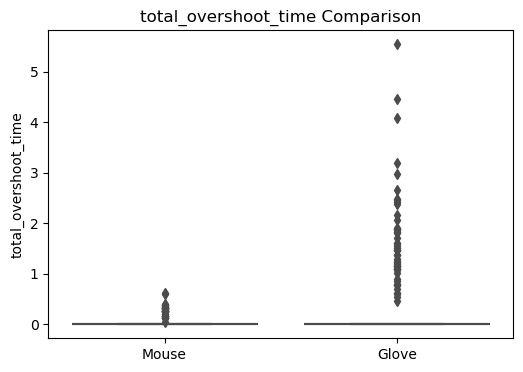

first_entry_click_delay:
  Mouse Mean: 0.3424
  Glove Mean: 0.7349
  t-statistic: -7.3324, p-value: 0.0000
----------------------------------------


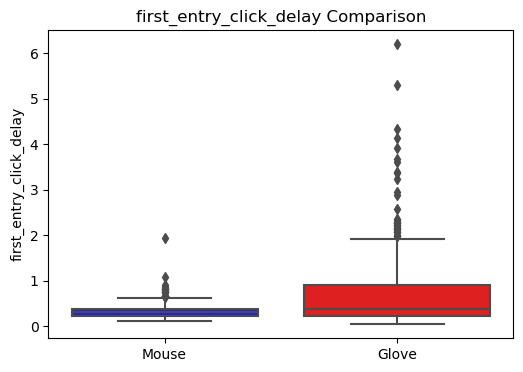

most_recent_click_delay:
  Mouse Mean: 0.2953
  Glove Mean: 0.4101
  t-statistic: -5.3591, p-value: 0.0000
----------------------------------------


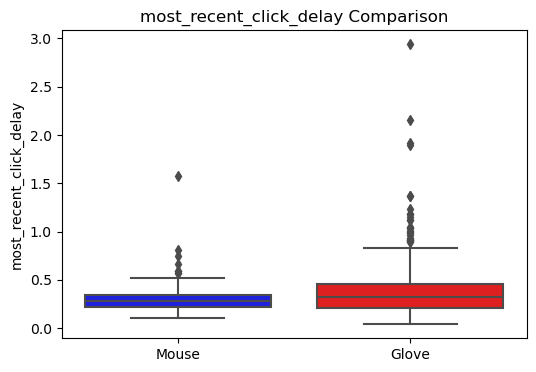

In [189]:
df_glove = df_glove[df_glove["error_count"] < 10]
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Convert list-based metrics to numerical values
df_mouse["total_errors"] = df_mouse["errors"].apply(len)
df_glove["total_errors"] = df_glove["errors"].apply(len)

df_mouse["total_corrections"] = df_mouse["overshoot_correction_times"].apply(len)
df_glove["total_corrections"] = df_glove["overshoot_correction_times"].apply(len)

# Define movement and error metrics
movement_metrics = ["optimal_path_ratio", "extra_movement_percentage"]
error_metrics = ["total_errors", "error_count", "total_corrections"]  # Use counts instead of lists
time_based_errors = ["hover_time", "total_overshoot_time", "first_entry_click_delay", "most_recent_click_delay"]

# Function to summarize and compare metrics
def summarize_and_compare(df_mouse, df_glove, metrics, title):
    print(f"\n### {title} ###\n")

    for metric in metrics:
        mouse_mean = df_mouse[metric].mean()
        glove_mean = df_glove[metric].mean()
        stat, p_value = ttest_ind(df_mouse[metric], df_glove[metric], equal_var=False)  # Welch's t-test
        
        print(f"{metric}:")
        print(f"  Mouse Mean: {mouse_mean:.4f}")
        print(f"  Glove Mean: {glove_mean:.4f}")
        print(f"  t-statistic: {stat:.4f}, p-value: {p_value:.4f}")
        print("-" * 40)

        # Visualization
        plt.figure(figsize=(6, 4))
        sns.boxplot(data=[df_mouse[metric], df_glove[metric]], palette=["blue", "red"])
        plt.xticks([0, 1], ["Mouse", "Glove"])
        plt.title(f"{metric} Comparison")
        plt.ylabel(metric)
        plt.show()

# Run comparisons
summarize_and_compare(df_mouse, df_glove, movement_metrics, "Movement Efficiency")
summarize_and_compare(df_mouse, df_glove, error_metrics, "Error Metrics")
summarize_and_compare(df_mouse, df_glove, time_based_errors, "Time-Based Error Handling")




### Total Overshoot Correction Time ###

total_correction_time:
  Mouse Mean: 0.0377
  Glove Mean: 0.2924
  t-statistic: -5.6669, p-value: 0.0000
----------------------------------------


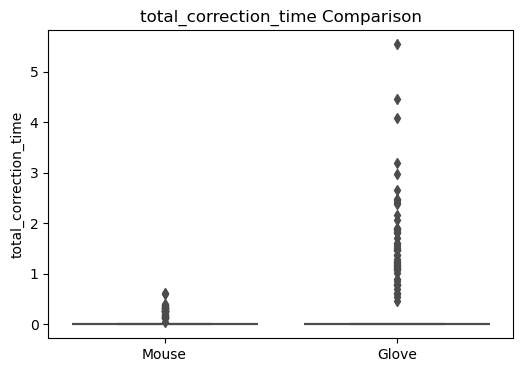


### Average Overshoot Correction Time per Fix ###

avg_correction_time:
  Mouse Mean: 0.0347
  Glove Mean: 0.2690
  t-statistic: -5.8781, p-value: 0.0000
----------------------------------------


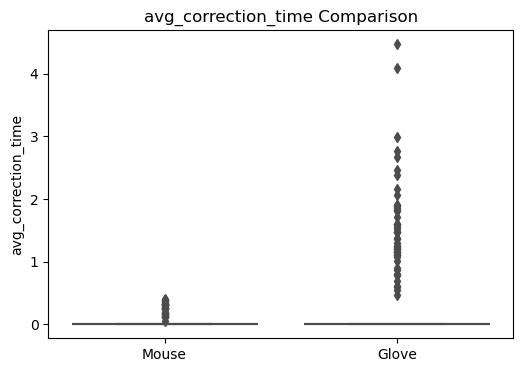

In [190]:
# Compute total and average correction time per trial
df_mouse["total_correction_time"] = df_mouse["overshoot_correction_times"].apply(lambda x: sum(x) if len(x) > 0 else 0)
df_mouse["avg_correction_time"] = df_mouse["overshoot_correction_times"].apply(lambda x: np.mean(x) if len(x) > 0 else 0)

df_glove["total_correction_time"] = df_glove["overshoot_correction_times"].apply(lambda x: sum(x) if len(x) > 0 else 0)
df_glove["avg_correction_time"] = df_glove["overshoot_correction_times"].apply(lambda x: np.mean(x) if len(x) > 0 else 0)

# Compare total correction time per trial
summarize_and_compare(df_mouse, df_glove, ["total_correction_time"], "Total Overshoot Correction Time")

# Compare average correction time per trial
summarize_and_compare(df_mouse, df_glove, ["avg_correction_time"], "Average Overshoot Correction Time per Fix")


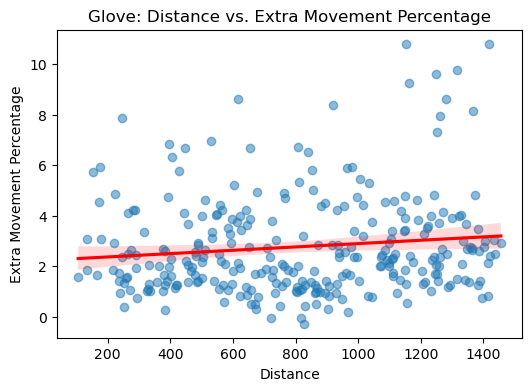

Spearman Correlation (Distance vs. Extra Movement %): 0.1129, p-value: 0.0540


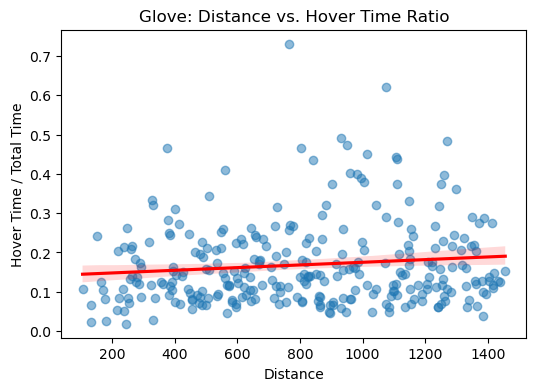

Spearman Correlation (Distance vs. Hover Time Ratio): 0.1038, p-value: 0.0766


In [191]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

# Scatter plot for distance vs. extra_movement_percentage
plt.figure(figsize=(6, 4))
sns.regplot(x=df_glove["distance"], y=df_glove["extra_movement_percentage"], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Distance")
plt.ylabel("Extra Movement Percentage")
plt.title("Glove: Distance vs. Extra Movement Percentage")
plt.show()

# Correlation for extra movement
corr_extra, p_extra = spearmanr(df_glove["distance"], df_glove["extra_movement_percentage"])
print(f"Spearman Correlation (Distance vs. Extra Movement %): {corr_extra:.4f}, p-value: {p_extra:.4f}")

# Compute hover_time as a fraction of total_time
df_glove["hover_ratio"] = df_glove["hover_time"] / df_glove["total_time"]

# Scatter plot for distance vs. hover_time / total_time
plt.figure(figsize=(6, 4))
sns.regplot(x=df_glove["distance"], y=df_glove["hover_ratio"], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Distance")
plt.ylabel("Hover Time / Total Time")
plt.title("Glove: Distance vs. Hover Time Ratio")
plt.show()

# Correlation for hover time ratio
corr_hover, p_hover = spearmanr(df_glove["distance"], df_glove["hover_ratio"])
print(f"Spearman Correlation (Distance vs. Hover Time Ratio): {corr_hover:.4f}, p-value: {p_hover:.4f}")


In [192]:
import numpy as np

# Extract overshoot correction times from glove data
glove_correction_times = [t for sublist in df_glove["overshoot_correction_times"] for t in sublist]

# Compute statistics
mean_correction_time = np.mean(glove_correction_times)
median_correction_time = np.median(glove_correction_times)
std_correction_time = np.std(glove_correction_times)

# Print results
print("Glove Overshoot Correction Time Analysis:")
print(f"Mean Correction Time: {mean_correction_time:.4f} sec")
print(f"Median Correction Time: {median_correction_time:.4f} sec")
print(f"Standard Deviation: {std_correction_time:.4f} sec")


Glove Overshoot Correction Time Analysis:
Mean Correction Time: 1.5525 sec
Median Correction Time: 1.4670 sec
Standard Deviation: 0.7976 sec


In [193]:
print(df_glove.columns)
df_glove.head()

Index(['timestamp', 'trial', 'total_time', 'distance', 'target_shape',
       'target_position', 'errors', 'overshoot_correction_times', 'hover_time',
       'first_entry_click_delay', 'most_recent_click_delay',
       'prev_target_distance', 'velocity', 'error_count',
       'total_overshoot_time', 'actual_path_length', 'optimal_path_ratio',
       'extra_movement_percentage', 'session_cursor_path', 'W', 'ID',
       'throughput', 'total_errors', 'total_corrections',
       'total_correction_time', 'avg_correction_time', 'hover_ratio'],
      dtype='object')


,timestamp,trial,total_time,distance,target_shape,target_position,errors,overshoot_correction_times,hover_time,first_entry_click_delay,...,extra_movement_percentage,session_cursor_path,W,ID,throughput,total_errors,total_corrections,total_correction_time,avg_correction_time,hover_ratio
0,2025-03-29T18:37:19.074Z,1,2.800,1348.45,long-circle,"(1333.1, 202.9)",[],[0.782],0.813,1.248,...,2.681953,"[(0, 720, 325), (239.2, 612.0, 407.0), (253.3,...",100,2.858260,1.020807,0,1,0.782,0.782,0.290357
1,2025-03-29T18:37:19.074Z,2,3.112,1258.76,rectangle,"(1150.0, 511.8)",[],[],1.238,1.238,...,3.713813,"[(0, 1333.1, 202.9), (263.0, 1383.0, 361.0), (...",100,2.198773,0.706547,0,0,0.000,0.000,0.397815
2,2025-03-29T18:37:19.074Z,3,4.042,690.23,square,"(470.0, 505.5)",[],[1.884],0.870,2.361,...,1.731649,"[(0, 1150.0, 511.8), (457.2, 1174.0, 668.0), (...",50,3.867954,0.956941,0,1,1.884,1.884,0.215240
3,2025-03-29T18:37:19.074Z,4,3.912,1250.33,long-rectangle,"(1243.8, 127.7)",[],[1.1],1.466,1.883,...,1.672978,"[(0, 470.0, 505.5), (347.0, 486.0, 667.0), (36...",50,4.187615,1.070454,0,1,1.100,1.100,0.374744
4,2025-03-29T18:37:19.074Z,5,1.831,1111.65,rectangle,"(1073.7, 288.1)",[],[],0.510,0.510,...,2.308779,"[(0, 1243.8, 127.7), (426.6, 1274.0, 283.0), (...",100,2.187830,1.194882,0,0,0.000,0.000,0.278536


In [194]:
import statsmodels.api as sm

# Convert categorical variable 'target_shape' to numerical codes
df_glove["target_shape"] = df_glove["target_shape"].astype("category").cat.codes

# Define predictor variables (features) and target variable
predictors = ["distance", "ID", "extra_movement_percentage", "hover_time", 
              "error_count", "total_overshoot_time", "first_entry_click_delay", 
              "most_recent_click_delay", "target_shape"]
target = "total_time"

# Extract data
X = df_glove[predictors]
y = df_glove[target]

# Add constant for the intercept
X = sm.add_constant(X)

# Fit OLS regression
model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             total_time   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     45.12
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           1.15e-49
Time:                        04:00:10   Log-Likelihood:                -336.60
No. Observations:                 292   AIC:                             693.2
Df Residuals:                     282   BIC:                             730.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [195]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Define the features we used in OLS
features = ['distance', 'ID', 'extra_movement_percentage', 'hover_time',
            'error_count', 'total_overshoot_time', 'first_entry_click_delay',
            'most_recent_click_delay', 'target_shape']

# Ensure categorical variables (target_shape) are numerical (if not already)
df_glove['target_shape'] = pd.factorize(df_glove['target_shape'])[0]

# Create the feature matrix (X)
X = df_glove[features]

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display results
print(vif_data)


                     Feature         VIF
0                   distance    6.319902
1                         ID    9.092083
2  extra_movement_percentage    2.707205
3                 hover_time   46.909970
4                error_count    2.016025
5       total_overshoot_time  353.328498
6    first_entry_click_delay  730.828853
7    most_recent_click_delay   85.091700
8               target_shape    4.363205


In [196]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Drop high VIF columns
df_glove_reduced = df_glove.drop(columns=["first_entry_click_delay", "total_overshoot_time", "most_recent_click_delay"])

# Recalculate VIF
X = df_glove_reduced[["distance", "ID", "extra_movement_percentage", "hover_time", 
                      "error_count", "target_shape"]]

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                     Feature       VIF
0                   distance  6.313738
1                         ID  8.867074
2  extra_movement_percentage  2.688308
3                 hover_time  2.510156
4                error_count  1.207529
5               target_shape  4.336430


In [ ]:
# Convert target_shape to numeric (if it's categorical)
df_glove["target_shape"] = df_glove["target_shape"].astype("category").cat.codes

# Define features again
mouse_features = ['distance', 'ID', 'extra_movement_percentage', 'hover_time', 'error_count', 'target_shape']
X_mouse = df_glove[mouse_features]
y_mouse = df_glove['total_time']

# Drop any remaining NaN values (just in case)
X_mouse = X_mouse.dropna()
y_mouse = y_mouse.loc[X_mouse.index]

# Add constant for OLS
X_mouse = sm.add_constant(X_mouse)

# Run OLS regression
model_mouse = sm.OLS(y_mouse, X_mouse).fit()

# Print results
print(model_mouse.summary())


                            OLS Regression Results                            
Dep. Variable:             total_time   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     52.93
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           1.35e-43
Time:                        04:00:10   Log-Likelihood:                -357.53
No. Observations:                 292   AIC:                             729.1
Df Residuals:                     285   BIC:                             754.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [198]:
# Convert target_shape to numeric (if it's categorical)
df_mouse['target_shape'] = pd.to_numeric(df_mouse['target_shape'], errors='coerce')

# Define features again
mouse_features = ['distance', 'ID', 'extra_movement_percentage', 'hover_time', 'error_count', 'target_shape']
X_mouse = df_mouse[mouse_features]
y_mouse = df_mouse['total_time']

# Drop any remaining NaN values (just in case)
X_mouse = X_mouse.dropna()
y_mouse = y_mouse.loc[X_mouse.index]

# Add constant for OLS
X_mouse = sm.add_constant(X_mouse)

# Run OLS regression
model_mouse = sm.OLS(y_mouse, X_mouse).fit()

# Print results
print(model_mouse.summary())


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Add a column indicating device type
df_glove["device_type"] = 1
df_mouse["device_type"] = 0

# Combine both datasets
df_combined = pd.concat([df_glove, df_mouse], ignore_index=True)

# Define predictors (excluding target variable 'total_time')
#predictors = ["distance", "ID", "extra_movement_percentage", "hover_time", "error_count", "target_shape"]
predictors = ["ID", "extra_movement_percentage", "hover_time", "error_count"]

# Create interaction terms
for col in predictors:
    df_combined[f"{col}_x_device"] = df_combined[col] * df_combined["device_type"]

# Define the final set of predictors (including interaction terms)
final_predictors = predictors + [f"{col}_x_device" for col in predictors] + ["device_type"]

# Prepare the data for OLS
X = df_combined[final_predictors]
y = df_combined["total_time"]
X = sm.add_constant(X)  # Add constant term

# Run OLS
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             total_time   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     212.6
Date:                Mon, 31 Mar 2025   Prob (F-statistic):          7.37e-170
Time:                        03:57:04   Log-Likelihood:                -505.64
No. Observations:                 542   AIC:                             1031.
Df Residuals:                     532   BIC:                             1074.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons